In [1]:
import requests
import os

# Data source: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
url = "https://data.humdata.org/hxlproxy/data/download/time_series_covid19_confirmed_global_narrow.csv?dest=data_edit&filter01=explode&explode-header-att01=date&explode-value-att01=value&filter02=rename&rename-oldtag02=%23affected%2Bdate&rename-newtag02=%23date&rename-header02=Date&filter03=rename&rename-oldtag03=%23affected%2Bvalue&rename-newtag03=%23affected%2Binfected%2Bvalue%2Bnum&rename-header03=Value&filter04=clean&clean-date-tags04=%23date&filter05=sort&sort-tags05=%23date&sort-reverse05=on&filter06=sort&sort-tags06=%23country%2Bname%2C%23adm1%2Bname&tagger-match-all=on&tagger-default-tag=%23affected%2Blabel&tagger-01-header=province%2Fstate&tagger-01-tag=%23adm1%2Bname&tagger-02-header=country%2Fregion&tagger-02-tag=%23country%2Bname&tagger-03-header=lat&tagger-03-tag=%23geo%2Blat&tagger-04-header=long&tagger-04-tag=%23geo%2Blon&header-row=1&url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv"
dataPath = 'time_series_covid19_confirmed_global.csv'
datafile = requests.get(url)
open(dataPath, 'wb').write(datafile.content)



765306

[  0   1   1   3   3   4   5   8   8   9  10  10  10  10  11  11  16  16
  17  18  18  18  18  18  18  18  20  22  22  23  24  26  26  28  30  31
  32  32  34  39  40  41  42  42  44  45  45  45  45  47  48  49  50  53
  59  67  77 100 108 135 153 169 195 215 235 252 267 283 298 306]
[ 1  0  2  0  1  1  3  0  1  1  0  0  0  1  0  5  0  1  1  0  0  0  0  0
  0  2  2  0  1  1  2  0  2  2  1  1  0  2  5  1  1  1  0  2  1  0  0  0
  2  1  1  1  3  6  8 10 23  8 27 18 16 26 20 20 17 15 16 15  8]
Min(n, plus, err) 9 5 17.617428597633058
err:  24.1149449255374


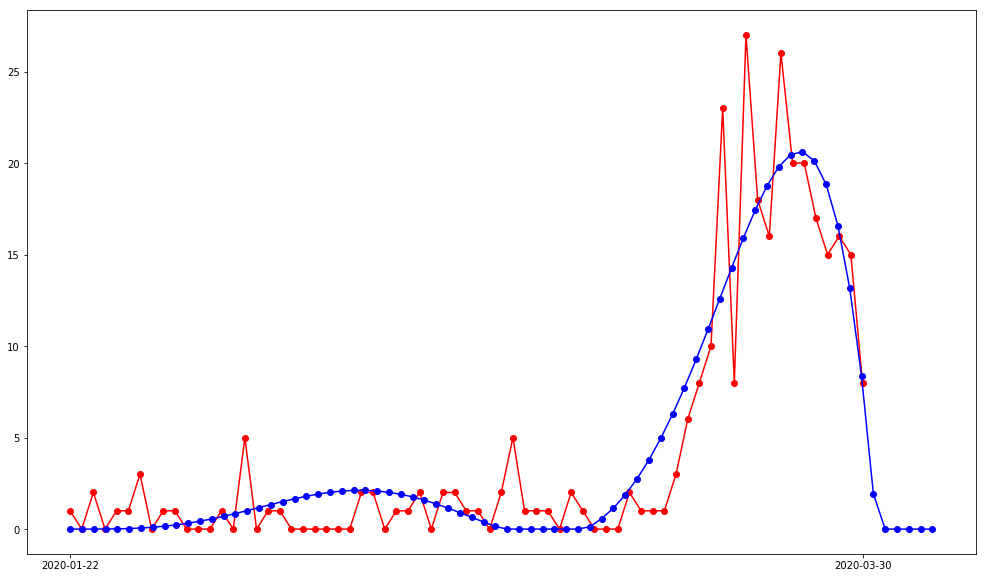

In [12]:
import pandas 
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def covidModel(Days, Values, degree):
    m = Days.size
    A = np.ones([m, degree])
    for i in range(1, degree):
        A[:, i] = A[:, i - 1] * Days    
    R = np.linalg.lstsq(A, Values, rcond = None)
    X = np.array(R[0])
    return X

def predic(X, Days):
    m = Days.size
    n = X.size
    A = np.ones([m, n])
    for i in range(1, n):
        A[:, i] = A[:, i - 1] * Days
    P = np.matmul(A, X)    
    return P

def test(X, Days, Values, ord=None ):
    P = predic(X, Days)
    D = Values - P
    #print('TEST', Days, Values, P)
    err = np.linalg.norm(D)
    #err = np.sum(np.abs(D))
    return err

    
df = pandas.read_csv(dataPath)
#df = df.loc[ df['Country/Region'] == 'China' ]
#dfS = df.loc[ df['Province/State'] == 'Hubei']
dfS = df.loc[ df['Country/Region'] == 'Taiwan*' ]
#dfS = df.loc[ df['Country/Region'] == 'Italy' ]
#dfS = df.loc[ df['Province/State'] == 'New York']
#dfS = df.loc[ df['Country/Region'] == 'US' ]
Values = np.flip(dfS['Value'].to_numpy(dtype = 'int'))
Values = np.concatenate([[0], Values])
print(Values)
Values = np.diff(Values)
print(Values)
nDays = Values.size
Date = np.flip(dfS['Date'].to_numpy())
Days = np.linspace(0.0, nDays - 1, nDays)
nTest = 14

ValuesTest = Values[-nTest:]
DaysTest = Days[-nTest:]

plusV = 0
maxDegree = 10 # the degee of polynomial
maxPlusDay = 180
minErr = np.Infinity
minN = -1
minPlus = -1
Xmin = None
for n in range(2, maxDegree):
    for plus in range(maxPlusDay):
        ValuesTrain = Values[0: ]
        DaysTrain = Days[0: ]
        nTrain = DaysTrain.size
        if plus > 0:
            ValuesTrain = np.concatenate((ValuesTrain, np.array([plusV])))
            DaysTrain = np.concatenate((DaysTrain, [nDays + plus]))
        nTrain = DaysTrain.size
        X = covidModel(DaysTrain, ValuesTrain, n)
        err = test(X, DaysTest, ValuesTest, ord = 1)
        #print ('(n, plus, err)', n, plus, err)
        if err < minErr:
            Xmin = X
            minN = n
            minPlus = plus
            minErr = err
            
print ('Min(n, plus, err)', minN, minPlus, minErr)
future = min(10, minPlus)
m2 = Values.size + future
DaysTest = np.linspace(0.0, m2, m2)
B = np.ones([m2, n])
for i in range(1, n):
    B[:, i] = B[:, i - 1] * DaysTest
P = np.matmul(B, X)

P = np.clip(P, 0.0, np.max(P))
err = np.linalg.norm(P[0:Values.size] - Values)
print('err: ', err)
plt.figure(figsize=(17,10))
plt.plot(Days, Values, 'ro')
plt.plot(Days, Values, linestyle='solid', color='red')
plt.plot(DaysTest, P, linestyle='solid', color = 'blue')
plt.plot(DaysTest, P, 'bo')
plt.xticks([0, Values.size - 1], [Date[0], Date[-1]])
plt.show()


In [23]:
import pandas 
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

df = pandas.read_csv(dataPath)
df = df.drop(columns=['Lat', 'Long'])
df = df.drop([0])
GC = df.groupby(['Country/Region', 'Province/State'])
for dfc in GC:
    print(dfc)



(('Australia', 'Australian Capital Territory'),                    Province/State Country/Region        Date Value
505  Australian Capital Territory      Australia  2020-03-24    39
506  Australian Capital Territory      Australia  2020-03-23    32
507  Australian Capital Territory      Australia  2020-03-22    19
508  Australian Capital Territory      Australia  2020-03-21     9
509  Australian Capital Territory      Australia  2020-03-20     6
..                            ...            ...         ...   ...
563  Australian Capital Territory      Australia  2020-01-26     0
564  Australian Capital Territory      Australia  2020-01-25     0
565  Australian Capital Territory      Australia  2020-01-24     0
566  Australian Capital Territory      Australia  2020-01-23     0
567  Australian Capital Territory      Australia  2020-01-22     0

[63 rows x 4 columns])
(('Australia', 'New South Wales'),       Province/State Country/Region        Date Value
568  New South Wales      Australia

[63 rows x 4 columns])
(('Netherlands', 'Sint Maarten'),       Province/State Country/Region        Date Value
11152   Sint Maarten    Netherlands  2020-03-24     2
11153   Sint Maarten    Netherlands  2020-03-23     2
11154   Sint Maarten    Netherlands  2020-03-22     1
11155   Sint Maarten    Netherlands  2020-03-21     1
11156   Sint Maarten    Netherlands  2020-03-20     1
...              ...            ...         ...   ...
11210   Sint Maarten    Netherlands  2020-01-26     0
11211   Sint Maarten    Netherlands  2020-01-25     0
11212   Sint Maarten    Netherlands  2020-01-24     0
11213   Sint Maarten    Netherlands  2020-01-23     0
11214   Sint Maarten    Netherlands  2020-01-22     0

[63 rows x 4 columns])
(('United Kingdom', 'Bermuda'),       Province/State  Country/Region        Date Value
14365        Bermuda  United Kingdom  2020-03-24     6
14366        Bermuda  United Kingdom  2020-03-23     6
14367        Bermuda  United Kingdom  2020-03-22     6
14368        Bermud